## Black-Litterman Model for Portfolio Optimization

The Black-Litterman model is a sophisticated Bayesian and mathematical framework used to optimize asset allocation in a portfolio. Developed by Fischer Black and Robert Litterman in 1990 at Goldman Sachs, it incorporates investor views and market equilibrium returns to overcome the limitations of modern portfolio theory and traditional mean-variance optimization (MVO). Key Components:

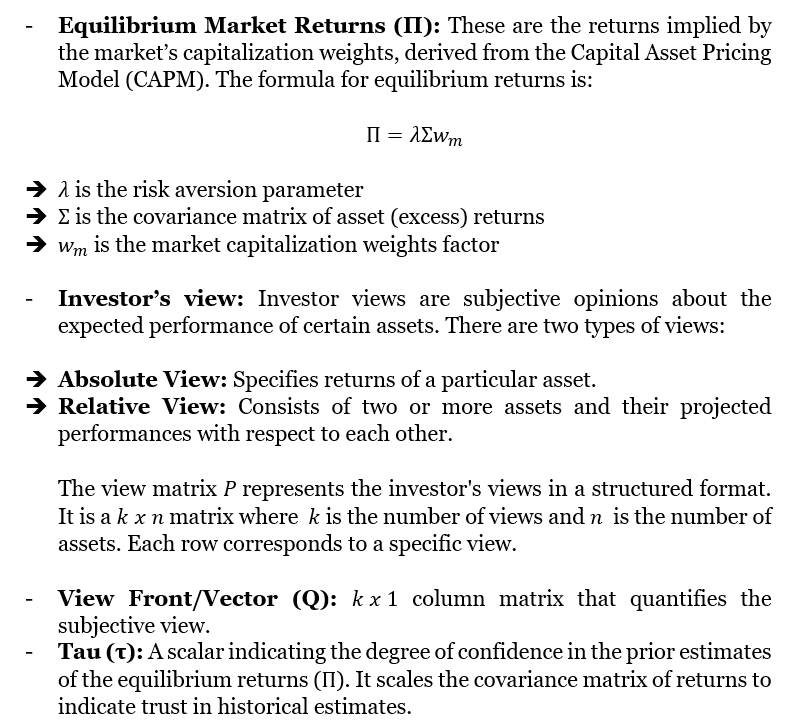

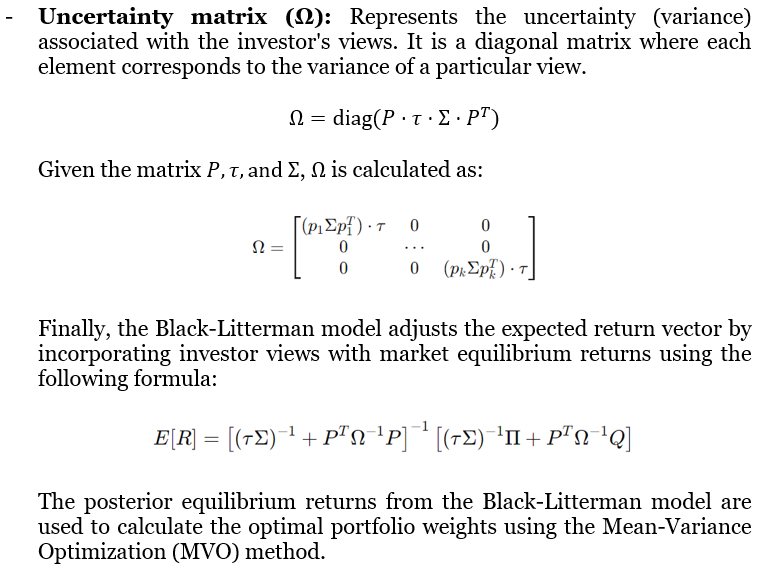

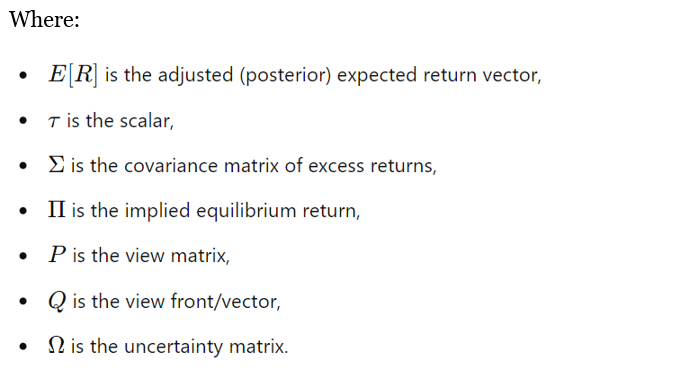

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import inv
import yfinance as yf
from scipy.optimize import minimize

# Fetch historical returns for the portfolio components
# Using yfinance to get data from 2019 until 2024
tickers = ['TSLA', 'NVDA', 'AAPL', 'AMZN', 'MSFT', 'GOOGL', 'META', 'NFLX', 'BRK-B', 'JNJ']
data = yf.download(tickers, start="2019-01-01", end="2024-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

returns.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,AAPL,AMZN,BRK-B,GOOGL,JNJ,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,,,
2019-01-03,-0.099608,-0.025241,-0.054931,-0.027696,-0.015890,-0.029039,-0.036788,0.013226,-0.060417,-0.031472
2019-01-04,0.042689,0.050064,0.018470,0.051294,0.016784,0.047138,0.046509,0.097234,0.064067,0.057697
2019-01-07,-0.002226,0.034353,0.008760,-0.001994,-0.006415,0.000725,0.001275,0.059717,0.052941,0.054361
2019-01-08,0.019063,0.016612,-0.003047,0.008783,0.023227,0.032452,0.007251,0.015634,-0.024895,0.001164
2019-01-09,0.016981,0.001714,0.000306,-0.003427,-0.007926,0.011927,0.014299,-0.000968,0.019667,0.009483


In [ ]:
# Calculate the mean annual returns and covariance matrix
mean_returns = returns.mean() * 252  # Annualizing the mean returns
cov_matrix = returns.cov() * 252  # Annualizing the covariance matrix

print(mean_returns, cov_matrix)

Ticker
AAPL     0.378031
AMZN     0.198360
BRK-B    0.136967
GOOGL    0.245988
JNJ      0.087829
META     0.289079
MSFT     0.320295
NFLX     0.230516
NVDA     0.671826
TSLA     0.708129
dtype: float64 Ticker      AAPL      AMZN     BRK-B     GOOGL       JNJ      META      MSFT  \
Ticker                                                                         
AAPL    0.103907  0.070302  0.040678  0.069207  0.025977  0.083255  0.074562   
AMZN    0.070302  0.124055  0.029163  0.073902  0.015960  0.094286  0.073346   
BRK-B   0.040678  0.029163  0.047530  0.037010  0.023811  0.038174  0.037568   
GOOGL   0.069207  0.073902  0.037010  0.101188  0.021901  0.093134  0.073616   
JNJ     0.025977  0.015960  0.023811  0.021901  0.039455  0.021076  0.025299   
META    0.083255  0.094286  0.038174  0.093134  0.021076  0.190358  0.082489   
MSFT    0.074562  0.073346  0.037568  0.073616  0.025299  0.082489  0.092969   
NFLX    0.069132  0.089998  0.027035  0.068475  0.015529  0.101616  0.068986  

In [ ]:
# Define market capitalization weights
# Fetch market capitalizations using yfinance
market_caps = []
for ticker in tickers:
    stock_info = yf.Ticker(ticker).info
    market_caps.append(stock_info['marketCap'])

market_caps = np.array(market_caps)

print(market_caps)

# Market capitalization weights
market_weights = market_caps / np.sum(market_caps)

print(market_weights)

[ 631078912000 3038874173440 3229668081664 2011075444736 3321870942208
 2257913118720 1278969118720  290806464512  877882572800  351760351232]
[0.03649986 0.17576009 0.18679508 0.11631505 0.19212784 0.13059146
 0.07397204 0.01681944 0.0507743  0.02034485]


In [ ]:
# Calculate the implied equilibrium returns
# Risk aversion coefficient (lambda)
risk_aversion = 2.5

# The risk-aversion coefficient (λ) indicates the expected tradeoff between risk and return.
# It represents how much return an investor is willing to give up for reduced risk.
# In the reverse optimization process, λ serves as a scaling factor for estimating excess returns.
# The weighted reverse-optimized excess returns align with the specified market risk premium.
# A higher λ means more excess return per unit of risk, resulting in higher estimated excess returns.
# It is essentially the Sharpe Ratio divided by the standard deviation of market returns.

# Implied equilibrium returns (Pi)
implied_returns = risk_aversion * np.dot(cov_matrix, market_weights)

print(implied_returns) # Pi

[0.15495807 0.17085949 0.08993392 0.16032575 0.06178013 0.20661483
 0.1558756  0.16099286 0.23230468 0.19922142]


In [ ]:
# Define the views and confidence levels

# Each row of the matrix P corresponds to a view on one stock.
# We use an identity matrix here because we have one view per stock.
# P[i, j] = 1 if the view is on stock j, 0 otherwise.
P = np.eye(len(tickers))

# Define the expected excess returns for each stock in the views.
# This array Q contains the expected return adjustments (views) for each stock:
# Q[0] = 0.05 -> We expect TSLA to have an excess return of 5%
# Q[1] = 0.04 -> We expect NVDA to have an excess return of 4%
# Q[2] = 0.03 -> We expect AAPL to have an excess return of 3%
# Q[3] = 0.06 -> We expect AMZN to have an excess return of 6%
# Q[4] = 0.05 -> We expect MSFT to have an excess return of 5%
# Q[5] = 0.04 -> We expect GOOGL to have an excess return of 4%
# Q[6] = 0.03 -> We expect META to have an excess return of 3%
# Q[7] = 0.07 -> We expect NFLX to have an excess return of 7%
# Q[8] = 0.02 -> We expect BRK-B to have an excess return of 2%
# Q[9] = 0.03 -> We expect JNJ to have an excess return of 3%
Q = np.array([0.05, 0.04, 0.03, 0.06, 0.05, 0.04, 0.03, 0.07, 0.02, 0.03])

# Step 5: Define the uncertainty matrix (Omega)
# Typically, Omega is a diagonal matrix with the variances of the views.
# For simplicity, we'll assume a fixed variance for each view.

# view_confidences represents our confidence in each view.
# Smaller values mean higher confidence in the view.
# Here, we use 0.0001 times the number of tickers to represent high confidence in each view.
# view_confidences[i] = 0.0001 for all i indicates we have very high confidence in all views.
view_confidences = np.array([0.0001] * len(tickers))

# Omega is a diagonal matrix where each diagonal element represents the uncertainty (variance) of each view.
# Because view_confidences are small (high confidence), Omega will have small values on the diagonal.
Omega = np.diag(view_confidences)

print(Omega)

[[0.0001 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0001 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0001 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0001]]


In [ ]:
# Calculate the posterior returns

# Tau is a scaling factor for the covariance matrix
# It reflects the confidence in the prior estimates of the returns
# A smaller tau implies less confidence in the historical estimates, thus giving more weight to the investor's views (prior)
# Smaller values of tau indicate more confidence in the prior
tau = 0.025

# Adjusted covariance matrix
# Multiply the covariance matrix by tau to scale it
# This scaling adjusts the covariance matrix to reflect the confidence level
adjusted_cov_matrix = tau * cov_matrix

# Calculate the posterior returns using the Black-Litterman formula
# M_inverse is the inverse of the matrix that incorporates both the investor views and the adjusted covariance matrix
# P.T is the transpose of the view matrix P
# inv(Omega) is the inverse of the uncertainty matrix Omega
# inv(adjusted_cov_matrix) is the inverse of the adjusted covariance matrix
# The formula combines the views and the market equilibrium to adjust the mean returns
M_inverse = inv(np.dot(P.T, inv(Omega)).dot(P) + inv(adjusted_cov_matrix))

# adjusted_mean_returns is calculated by combining the weighted views (P.T @ inv(Omega) @ Q) and the market equilibrium returns
# This formula integrates the views and their confidence levels into the final adjusted returns
adjusted_mean_returns = M_inverse.dot(np.dot(P.T, inv(Omega)).dot(Q) + inv(adjusted_cov_matrix).dot(implied_returns))

print(adjusted_mean_returns)

[0.04916973 0.04143562 0.03210676 0.05831587 0.04754507 0.04190396
 0.03293476 0.06903733 0.02150321 0.0302687 ]


In [ ]:
# Define the optimization function to get non-negative weights that sum to 1

# Define a function to calculate the portfolio variance
# This function will be minimized to find the optimal portfolio weights
# weights.T is the transpose of the weight vector
# cov_matrix is the covariance matrix of the asset returns
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights    # This gives the portfolio variance

# Define constraints for the optimization
# The sum of the weights should be equal to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define bounds for the weights
# Each weight should be between 0 and 1 (no short selling)
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess for the weights
# Start with an equal allocation to each asset
initial_guess = np.array([1/len(tickers)] * len(tickers))

# To track the optimization process, we store the portfolio variances at each step
optimization_steps = []

# Define a callback function to track the optimization process
# This function appends the current portfolio variance to the optimization_steps list
def callback(x):
    optimization_steps.append(portfolio_variance(x, cov_matrix))

# Perform the optimization to find the optimal portfolio weights
# minimize is the optimization function from scipy.optimize
# We minimize the portfolio_variance function subject to the constraints and bounds
# The callback function is used to track the optimization process
optimal_result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints, callback=callback)

# The optimal weights are the result of the optimization
optimal_weights = optimal_result.x

print("Adjusted Mean Returns (Posterior):")
print(adjusted_mean_returns)
print("\nOptimal Portfolio Weights:")
print(optimal_weights)

Adjusted Mean Returns (Posterior):
[0.04916973 0.04143562 0.03210676 0.05831587 0.04754507 0.04190396
 0.03293476 0.06903733 0.02150321 0.0302687 ]

Optimal Portfolio Weights:
[0.00000000e+00 8.72205586e-02 3.11386577e-01 2.37420806e-18
 5.69690872e-01 2.00895232e-19 0.00000000e+00 3.17019919e-02
 6.19947033e-18 1.34056302e-18]


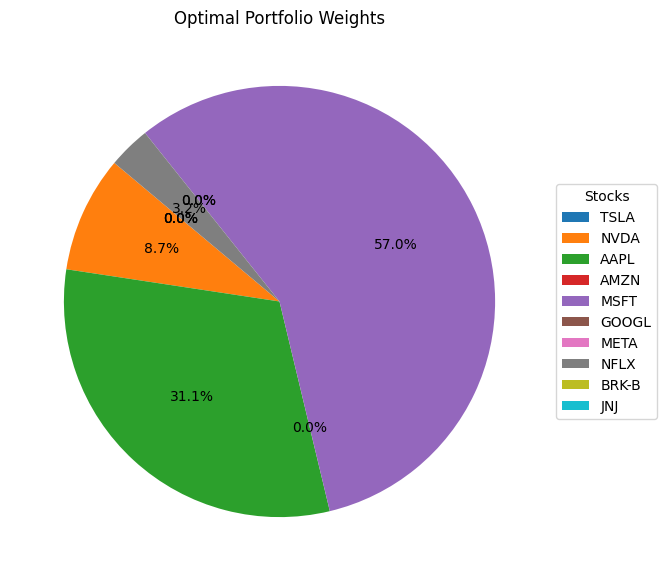

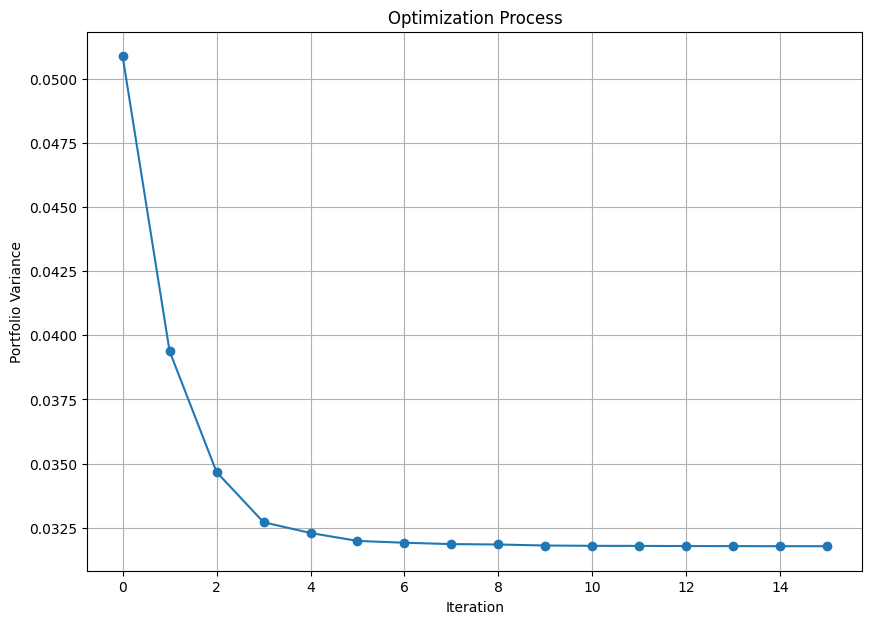

In [ ]:
# Plot the optimal portfolio weights
# Create a pie chart with labels in a legend
labels = ['TSLA', 'NVDA', 'AAPL', 'AMZN', 'MSFT', 'GOOGL', 'META', 'NFLX', 'BRK-B', 'JNJ']
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(optimal_weights, autopct='%1.1f%%', startangle=140)

# Add a legend with the labels
ax.legend(wedges, labels, title="Stocks", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Set the title
plt.title('Optimal Portfolio Weights')
plt.show()

# Plot the optimization process
plt.figure(figsize=(10, 7))
plt.plot(optimization_steps, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Portfolio Variance')
plt.title('Optimization Process')
plt.grid(True)
plt.show()